# ECG Anomaly detection using Autoencoder

* references
  * tensorflow.org/tutorials/generative/autoencoder
  * https://www.kaggle.com/code/devavratatripathy/ecg-anomaly-detection-using-autoencoders/notebook

In [24]:
import tensorflow as tf
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [31]:
# The last element contains the labels
labels = raw_data[:, -1]
labels

4998

In [4]:
# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]
data

array([[-0.11252183, -2.8272038 , -3.7738969 , ...,  0.12343082,
         0.92528624,  0.19313742],
       [-1.1008778 , -3.9968398 , -4.2858426 , ...,  0.77381971,
         1.1196209 , -1.4362499 ],
       [-0.56708802, -2.5934502 , -3.8742297 , ...,  0.32109663,
         0.90422673, -0.42179659],
       ...,
       [-1.1229693 , -2.2529248 , -2.8676281 , ..., -2.874136  ,
        -2.0083694 , -1.8083338 ],
       [-0.54770461, -1.8895451 , -2.8397786 , ...,  1.261335  ,
         1.1504486 ,  0.80493225],
       [-1.3517791 , -2.2090058 , -2.5202247 , ..., -2.2600228 ,
        -1.577823  , -0.68453092]])

In [5]:
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [6]:
# normalize the data to the range [0, 1] using linear scaling
# https://developers.google.com/machine-learning/data-prep/transform/normalization
# x' = (x-xmin)/(xmax-xmin)

# calculate the maximum and minimun value from the training set
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

# normalize the data using formula
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

# the data to float
train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

Metal device set to: Apple M1


2022-10-24 13:19:47.602638: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-24 13:19:47.603417: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
#The labels are either 0 or 1, so I will convert them into boolean(true or false) 
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

# get normal ecg data - for training, we use normal ecg only
normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

# get abnormal ecg data
anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]


In [9]:
import matplotlib.pyplot as plt

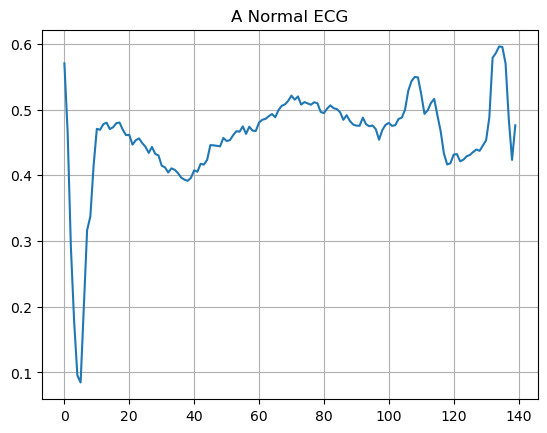

In [21]:
# plot normal ecg
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

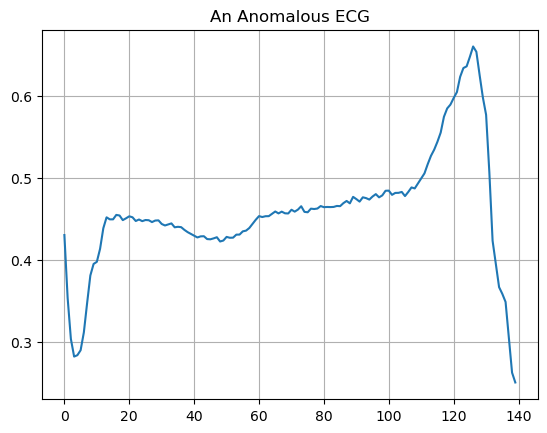

In [22]:
# plot anomalous ecg
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

In [25]:
# build anomaly detector
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(8, activation="relu")])
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(140, activation="sigmoid")])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [26]:
autoencoder = AnomalyDetector()

In [27]:
autoencoder.compile(optimizer='adam', loss='mae')

In [28]:
# train with normal, test with all
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20


2022-10-24 13:31:21.469920: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-24 13:31:22.053661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 3s 125ms/step - loss: 0.0582 - val_loss: 0.0527
Epoch 2/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0557 - val_loss: 0.0511
Epoch 3/20
1/5 [=====>........................] - ETA: 0s - loss: 0.0543

2022-10-24 13:31:24.573709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 10ms/step - loss: 0.0531 - val_loss: 0.0491
Epoch 4/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0496 - val_loss: 0.0475
Epoch 5/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0457 - val_loss: 0.0457
Epoch 6/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0416 - val_loss: 0.0440
Epoch 7/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0376 - val_loss: 0.0418
Epoch 8/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0341 - val_loss: 0.0407
Epoch 9/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0313 - val_loss: 0.0394
Epoch 10/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0290 - val_loss: 0.0384
Epoch 11/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0273 - val_loss: 0.0376
Epoch 12/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0261 - val_loss: 0.0369
Epoch 13/20
5/5 [=====================

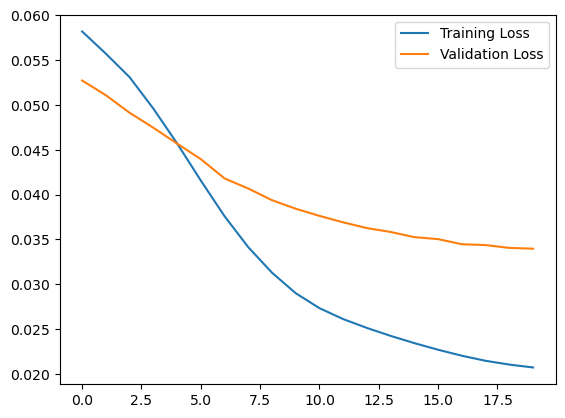

In [29]:
# plot train and validation loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

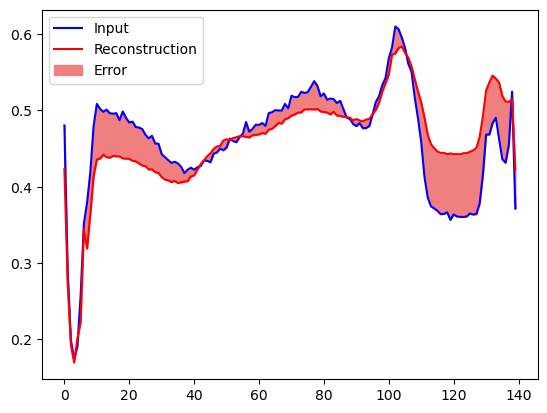

In [32]:
# recon error of training set
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

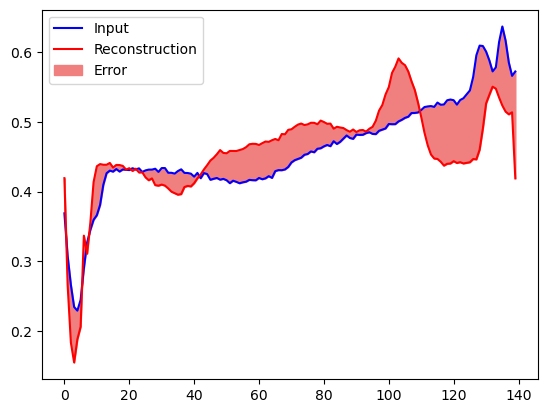

In [33]:
# recon error of test set
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(140), decoded_imgs[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [34]:
# detect anomaly
# if recon error > 1sd in normal train example, classify it as anomalous ecg

74/74 [==============================] - 0s 2ms/step


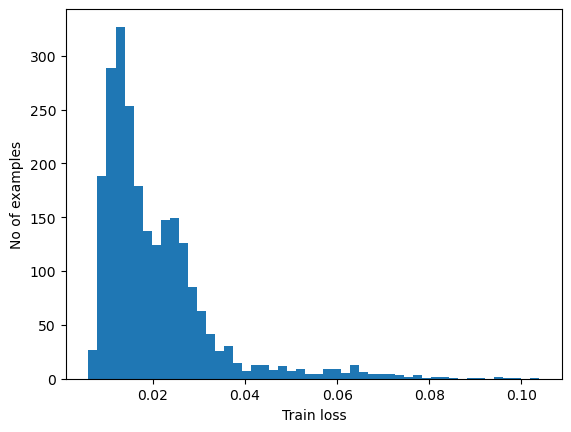

In [42]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [38]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.03312398


14/14 [==============================] - 0s 4ms/step


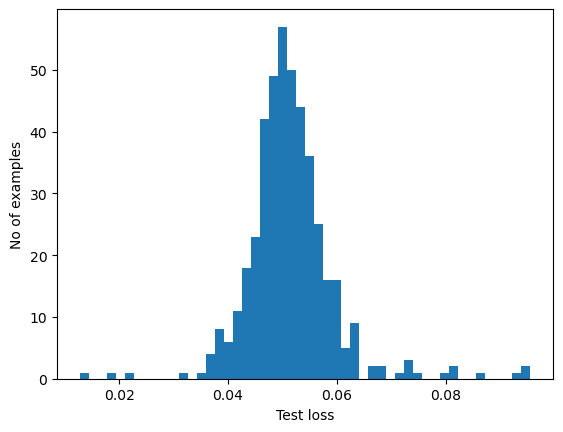

In [39]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [40]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, preds)))
    print("Precision = {}".format(precision_score(labels, preds)))
    print("Recall = {}".format(recall_score(labels, preds)))

In [41]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.944
Precision = 0.9921875
Recall = 0.9071428571428571
